# Install & import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd
import pandas

import copy
import os

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/home/caveman/PY38/lib/python3.8/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


In [3]:
try:
    from keras_visualizer import visualizer
except:
    !pip install keras-visualizer
    from keras_visualizer import visualizer

In [4]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from IPython.display import display, Image

2025-11-25 15:44:52.599089: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-25 15:44:52.674081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 15:44:54.035356: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package , function_name)
            return function
        else:
            return package

planar_drone = import_local_or_github('planar_drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')
generate_training_data_utility = import_local_or_github('generate_training_data_utility', directory='../Utility')
terrain_and_optic_flow_utility = import_local_or_github('terrain_and_optic_flow_utility', directory='../Utility')
keras_advanced_utility = import_local_or_github('keras_advanced_utility', directory='../Utility')
keras_ann_utility = import_local_or_github('keras_ann_utility', directory='../Utility')

# Load ANN model

In [6]:
model_weights = 'ray_estimator_weights.h5'
model_config = 'ray_estimator_config.json'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

ray_estimator_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('ray_estimator')

Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/ray_estimator_weights.h5
Successfully downloaded ray_estimator_weights.h5 (155192 bytes)
Fetching from: https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/ray_estimator_config.json
Successfully downloaded ray_estimator_config.json (584 bytes)
✓ Loaded configuration from: ray_estimator_config.json
✓ Model compiled with learning_rate=0.001
✓ Loaded weights from: ray_estimator_weights.h5

Model loaded successfully!
  Core input dim: 5
  Aux input dim: 115
  Jacobian weight: 0.1
  SV weight: 0.01


2025-11-25 15:46:22.348339: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Load fast inference model

In [8]:
ray_estimator_inference_model = keras_advanced_utility.create_fast_inference_model(ray_estimator_model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


# Load SVD compressor U matrices 

In [7]:
Ur_optic_flow_file = 'SVD_Ur_optic_flow.hdf'
Ur_ray_distance_file = 'SVD_Ur_ray_distance.hdf'

# If the model isn't here, download the pretrained model
for path in [model_weights, model_config]:
    if not os.path.exists(path):
        giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Trained_Models/'
        generate_training_data_utility.download_data(path, giturl=giturl, unzip=False)

Ur_optic_flow = pd.read_hdf(Ur_optic_flow_file).values
Ur_ray_distance = pd.read_hdf(Ur_ray_distance_file).values

# Simulate a new trajectory

This section is copied over from Lesson 17 B, so you can make changes to create an arbitrary trajectory.

### 1. Create a new trajectory

In [17]:
# Planar drone dynamics and measurements
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

# Time step
dt = 0.1

# Set up the simulator
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot']
input_names = ['j1', 'j2']
measurement_names = h(None, None, return_measurement_names=True)

simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


 <mark>This is the part you should consider changing</mark> to make the trajectory do something new and interesting. Note that the path it takes will still be limited by its dynamics -- the MPC will take care of that.

In [18]:
# First define the set-point(s) to follow
tsim = np.arange(0, 10.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 5*np.cos(2*np.pi*tsim*0.3),  # <<<< Do something interesting here
            'x_dot': NA,
            'z': 5*np.sin(2*np.pi*tsim*0.2)+0.5, # <<<<<< Do something interesting here
            'z_dot': NA,
           }

Run the MPC to make the drone follow the setpoints. Needs no adjustment.

In [19]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

# Set some bounds
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0
simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

Repackage the simulation results into a trajectory dataframe. Needs no adjustment.

In [20]:
t_sim_df = pd.DataFrame({'time': t_sim})
x_sim_df = pd.DataFrame(x_sim)
u_sim_df = pd.DataFrame(u_sim)
y_sim_df = pd.DataFrame(y_sim)

new_names = {key: 'sensor_' + key for key in y_sim_df}
y_sim_df = y_sim_df.rename(columns=new_names)

objid = pd.DataFrame({'objid': (1*np.ones_like(tsim)).astype(int)})

df = pd.concat([t_sim_df, objid, x_sim_df, u_sim_df, y_sim_df], axis=1)

trim_indices = 5
test_trajec = df.iloc[trim_indices:-trim_indices]

### 2. Create a new terrain profile

Get a terrain object, and <mark>replace the terrain attribute with something completely different from the training set</mark>.

Hint: you can get a sense of the training set terrain by visualizing a bunch of random seeds of the terrain object.

In [21]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=1)

# terrain.terrain defines the elevation profile, you can change in this in place.
# If you do, then you need to run this function so that subsequent functions that use the terrain object have the up-to-date profile.
terrain.__update_curve_points__()

../Utility/terrain_and_optic_flow_utility.py:147: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec.z += altitude_adjustment
../Utility/terrain_and_optic_flow_utility.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trajec['ventral_altitude'] = trajec.z.values - ventral_elevation_array


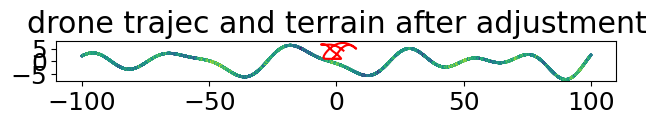

In [22]:
# adjust trajectory height
test_trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(test_trajec, terrain, plot=True)

### 3. Calculate the optic flow over time for this trajectory and visualize it.

In [23]:
result = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(test_trajec_adj, terrain)
imgs, analytic_optic_flows, ray_distances = result

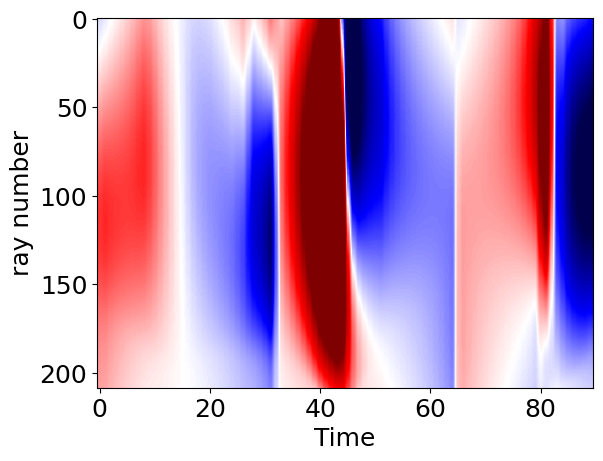

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(analytic_optic_flows, vmin=-3, vmax=3, cmap='seismic')
ax.set_ylabel('ray number')
ax.set_xlabel('Time')

ax.set_aspect('auto')

# Prepare the new trajectory for our ANN

## Helper function

This function collects a bunch of stuff that we did in the notebook Lesson 18 A in one place. 

In [48]:
def prepare_trajectory_for_ANN(trajec, optic_flow, ray_distance, Ur_optic_flow, Ur_ray_distance):

    # Make robust to taking either a np array or pandas dataframe
    try:
        optic_flow = optic_flow.values
    except:
        pass

    try:
        ray_distance = ray_distance.values
    except:
        pass

    # Compress and rename columns for optic flow
    optic_flow_compressed = Ur_optic_flow.T@optic_flow
    optic_flow_compressed = pd.DataFrame(optic_flow_compressed.T)

    original_column_names = optic_flow_compressed.keys()
    optic_flow_column_names = ['sensor_optic_flow_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, optic_flow_column_names))
    optic_flow_compressed = optic_flow_compressed.rename(columns=col_name_replacement)

    # Compress and rename columns for ray distances
    ray_distance_compressed = Ur_ray_distance.T@ray_distance
    ray_distance_compressed = pd.DataFrame(ray_distance_compressed.T)

    original_column_names = ray_distance_compressed.keys()
    ray_distance_column_names = ['ray_distance_reduc_' + str(i) for i in original_column_names]
    col_name_replacement = dict(zip(original_column_names, ray_distance_column_names))
    ray_distance_compressed = ray_distance_compressed.rename(columns=col_name_replacement)

    
    # Merge 
    df = pd.concat([trajec.reset_index(), 
                    optic_flow_compressed.reset_index(),
                    ray_distance_compressed.reset_index()], 
                    axis=1)
    df = df.drop(len(df)-1) # drop last row since it has nans

    # This stuff should all probably be in some config file...##########
    trim_edges = 5

    output_names = ray_distance_column_names 

    optic_flow_input_names = optic_flow_compressed.keys().tolist()
    other_input_names =  ['sensor_accel_x', 'sensor_accel_z']
    input_names = other_input_names + optic_flow_input_names

    time_window = 10
    input_offsets = np.arange(time_window)*-1
    output_offsets = [0]

    n_input = len(input_names) * time_window
    n_output = len(output_names)
    ######################################################################
    
    traj_augment = keras_ann_utility.collect_offset_rows(df[trim_edges:-1*trim_edges],
                                                       states=input_names,
                                                       controls=None,
                                                       outputs=output_names,
                                                       state_offsets=input_offsets,
                                                       control_offsets=None,
                                                       output_offsets=output_offsets)

    # Input data
    X = traj_augment.iloc[:, 0:n_input]

    # Output data
    Y = traj_augment.iloc[:, n_input:]

    ## Organize the data so we have the core data, and augmented (delay embedded) data
    #core_data = X.values[:,0:5]
    #aux_data = X.values[:,5:]
    #output_data = Y.values

    return df, traj_augment, X, Y

## Prep the trajectory

In [49]:
traj_combined_test, traj_timedelay_test, X_test, Y_test = prepare_trajectory_for_ANN(test_trajec_adj, 
                                                                                     analytic_optic_flows, 
                                                                                     ray_distances, 
                                                                                     Ur_optic_flow, 
                                                                                     Ur_ray_distance)

# Apply the ANN to get ray distance estimates

In [52]:
ray_estimate_compressed = ray_estimator_inference_model(tf.constant(X_test.values[:, 0:5]), 
                                                        tf.constant(X_test.values[:, 5:]))

2025-11-25 16:09:48.902918: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xe617c80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-25 16:09:48.903007: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-11-25 16:09:48.916646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 16:09:49.001589: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Reproject the low dimensional space into the original high dimensional space

In [53]:
ray_estimate_compressed = np.array(ray_estimate_compressed)
ray_estimate = Ur_ray_distance@ray_estimate_compressed.T

Check the shapes of things to make sure the sizes match up. 

In [57]:
ray_estimate.shape

(210, 70)

In [60]:
ray_distances.shape

(210, 90)

Need to drop the first and last few time points to make a fair comparison

In [64]:
trim_edges = 5
time_window = 10

ray_true = ray_distances[:,time_window+trim_edges:-1*trim_edges]
ray_true.shape

(210, 70)

Text(0, 0.5, 'Ray number')

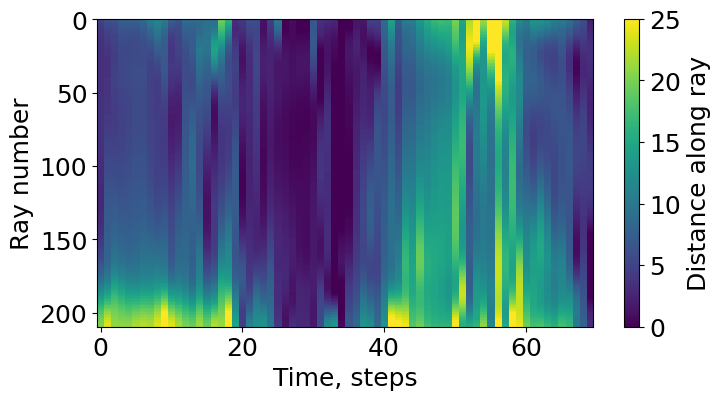

In [65]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_estimate, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

Text(0, 0.5, 'Ray number')

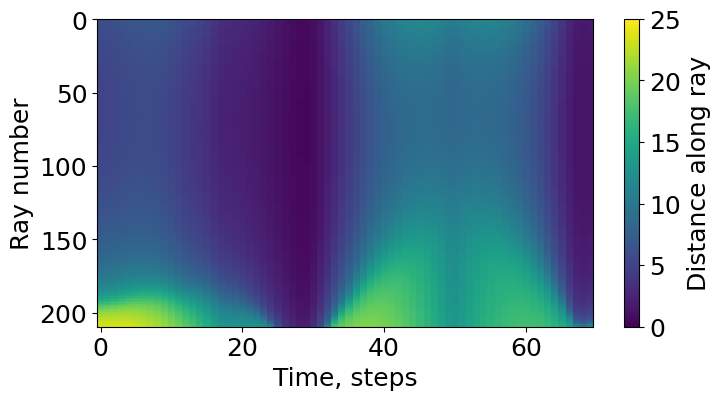

In [66]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

im = ax.imshow(ray_true, vmin=0, vmax=25, interpolation='nearest')
ax.set_aspect('auto')

fig.colorbar(im, ax=ax, label='Distance along ray')

ax.set_xlabel('Time, steps')
ax.set_ylabel('Ray number')

In [67]:
# low rank approximation of the ray estimates
ray_true_compressed_recon = Ur_ray_distance@(Ur_ray_distance.T@ray_true)

## Ventral altitude comparison

This is the center of the heatmaps above.

We can compare the ANN estimates (red), the true ray distances (black dashed), and the low rank model of the ray distances (blue dots).  

(0.0, 30.0)

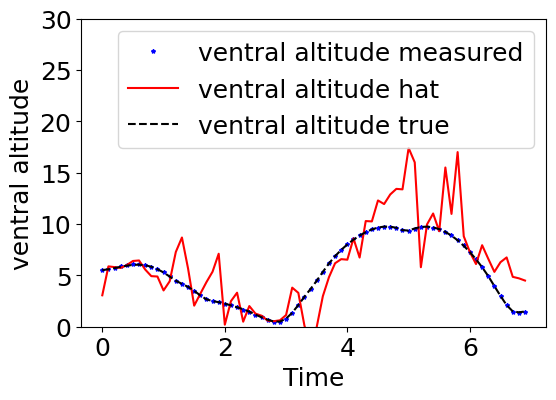

In [69]:
t_sim = np.arange(0, ray_estimate.shape[1]*0.1, 0.1)

ax = plot_tme(t_sim,
         ray_true_compressed_recon[105,:],
         ray_true[105,:],
         ray_estimate[105,:],
         label_var='ventral altitude',
         markersize=3)

ax.set_ylim(0, 30)

# Exercises / Future Directions

1. Compress the time delay embedded (augmented) input space with SVD. This should provide much more compression. Try compressing only the optic flow data, or all of the data.
2. Put the estimates for the compressed space in an AI-KF. 